In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import umap
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from modules.sparse_autoencoder import *
import pickle
import mygene
from tqdm import tqdm

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-13 17:10:30.654827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 17:10:31.311365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}

adata = anndata.read_h5ad("data/fede_count.h5ad")
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
adata.obs.index = adata.obs.index.astype('str')

anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs['class_name'] = anno_df['class_name']

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[(adata.obs.pct_counts_mt < 5), :]
#adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)
#sc.pp.scale(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)

# Create training and test AnnData objects
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

In [7]:
# Create dataset instances
train_dataset = AnnDataDataset(adata_train)
test_dataset = AnnDataDataset(adata_test)

In [8]:
n_inputs = adata.var.index.values.shape[0]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
# Initialize and train the autoencoder
autoencoder = Autoencoder(n_latents=50, n_inputs=n_inputs, activation=nn.ReLU(), tied=True, normalize=False).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

# Variable to keep track of the best test loss
best_test_loss = float('inf')

for epoch in range(100):
    autoencoder.train()
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        latents_pre_act, latents, recons = autoencoder(x)
        loss = F.mse_loss(recons, x)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Evaluate on the test set
    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].to(device)
            _, _, recons = autoencoder(x)
            test_loss += F.mse_loss(recons, x).item()
    test_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss}")

    # Check if the current test loss is the best we've seen so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        # Save the model
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
        print(f"Saved new best model with test loss: {best_test_loss}")


Epoch 1, Loss: 0.9213597178459167
Epoch 1, Test Loss: 1.022693866612138
Saved new best model with test loss: 1.022693866612138


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch 2, Loss: 0.782272458076477
Epoch 2, Test Loss: 0.9262526756202852
Saved new best model with test loss: 0.9262526756202852
Epoch 3, Loss: 1.7425627708435059
Epoch 3, Test Loss: 0.8624522990068874
Saved new best model with test loss: 0.8624522990068874
Epoch 4, Loss: 0.591474175453186
Epoch 4, Test Loss: 0.793997520329179
Saved new best model with test loss: 0.793997520329179
Epoch 5, Loss: 0.6498879790306091
Epoch 5, Test Loss: 0.7470875060236132
Saved new best model with test loss: 0.7470875060236132
Epoch 6, Loss: 0.3797231614589691
Epoch 6, Test Loss: 0.7171718089564426
Saved new best model with test loss: 0.7171718089564426
Epoch 7, Loss: 0.5376953482627869
Epoch 7, Test Loss: 0.6974490450040715
Saved new best model with test loss: 0.6974490450040715
Epoch 8, Loss: 0.9442988038063049
Epoch 8, Test Loss: 0.679152572074452
Saved new best model with test loss: 0.679152572074452
Epoch 9, Loss: 0.7278064489364624
Epoch 9, Test Loss: 0.6665740593059643
Saved new best model with test

In [15]:
# Initialize the autoencoder model
autoencoder = Autoencoder(n_latents=50, n_inputs=n_inputs, activation=nn.ReLU(), tied=True, normalize=False).to(device)
# Load the saved state dictionary
state_dict = torch.load('best_autoencoder.pth')
# Filter out unexpected keys
model_state_dict = autoencoder.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}

# Load the filtered state dictionary
autoencoder.load_state_dict(filtered_state_dict, strict=False)

# Set the model to evaluation mode
autoencoder.eval()

Autoencoder(
  (encoder): Linear(in_features=29015, out_features=50, bias=False)
  (activation): ReLU()
  (decoder): TiedTranspose(
    (linear): Linear(in_features=29015, out_features=50, bias=False)
  )
)

In [16]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)

In [17]:
autoencoder.cpu()

Autoencoder(
  (encoder): Linear(in_features=29015, out_features=50, bias=False)
  (activation): ReLU()
  (decoder): TiedTranspose(
    (linear): Linear(in_features=29015, out_features=50, bias=False)
  )
)

# UMAP

In [18]:
latents, _ = autoencoder.encode(data)
latents_np = latents.detach().numpy()
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(latents_np)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Top contributing genes for each latent dimension

In [38]:
# Extract encoder weights
encoder_weights = autoencoder.encoder.weight.detach().numpy()
# Get the gene names from the adata object
gene_names = adata.var_names
# Identify top contributing genes for each latent dimension
top_genes = {}
for i in range(encoder_weights.shape[0]):
    top_gene_indices = encoder_weights[i].argsort()[-50:][::-1]
    top_genes[i] = gene_names[top_gene_indices]
# Print the top genes for each latent dimension
for latent_dim, genes in top_genes.items():
    print(f"Latent dimension {latent_dim}: {', '.join(genes)}")

Latent dimension 0: Syt1, mt-Co1, Lsamp, Lrrc4c, Pcdh15, Pcdh9, Nrxn1, mt-Co2, Magi2, Meg3, Csmd1, Gria4, Brinp3, Tcf4, Adarb2, Astn2, Anks1b, mt-Atp6, Adgrl3, mt-Cytb, Ptprz1, Reln, Tenm2, mt-Nd4, Cntn5, Kcnh7, Grik1, Tenm3, Sema6d, Lhfpl3, Ncam1, Lrp1b, Ntm, Dlx6os1, Sgcz, Dnm3, Grid2, Dpp10, mt-Nd2, Npas3, mt-Nd1, Sox2ot, Dclk1, Dscam, Erbb4, Ptprt, Fry, Cdh20, Lrrtm4, Grin3a
Latent dimension 1: Meg3, Snhg11, Plp1, Cntnap2, Nrxn1, Pex5l, Epha6, Tenm2, Kcnh7, Slc8a1, Slc1a3, Phactr1, Nrxn3, Slc1a2, Ptprd, Adgrb3, Khdrbs2, Cntn4, Rian, Rgs20, Atp2b1, Pde1a, Kcnq5, Etl4, Galntl6, Prkcb, Grm3, Gabrb1, Ryr3, R3hdm1, Grm7, Mdga2, Prex2, Agbl4, Chrm3, Ndst3, Dlg2, Dmd, Grm5, Tenm4, Dpp10, Mgat4c, Hs6st3, Pde4b, Tenm3, Ntm, Arpp21, Pcdh9, Ptprn2, Tshz2
Latent dimension 2: Cntnap2, Adgrb3, Csmd1, mt-Co1, Gabrb1, Kcnd2, Ptgds, Galntl6, Opcml, Magi2, Nrg3, Trpm3, Dock10, Csmd3, Plp1, Atp1a2, Hexb, Nav3, Pcdh9, Dock4, mt-Co2, Adgrl3, Gria1, Tgfbr1, mt-Cytb, mt-Nd4, mt-Atp6, Mdga2, Sntg1, Gpc5, 

In [ ]:
all_df_results = []
for i in tqdm(range(50)):
    reference_list = adata.var.index.values
    reference_list = [x.upper() for x in reference_list.tolist()]
    gene_symbols = [x.upper() for x in top_genes[i].tolist()]
    
    mg = mygene.MyGeneInfo()
    gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='entrezgene', species='mouse')
    gene_list_ncbi = [entry.get('entrezgene') for entry in gene_info if 'entrezgene' in entry]
    background_genes_symbols = reference_list
    background_gene_info = mg.querymany(background_genes_symbols, scopes='symbol', fields='entrezgene', species='mouse')
    background_genes_ncbi = [entry.get('entrezgene') for entry in background_gene_info if 'entrezgene' in entry]
    gene_list_ncbi = [int(x) for x in gene_list_ncbi]
    background_genes_ncbi = [int(x) for x in background_genes_ncbi]
    df_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)
    all_df_results.append(df_results)

In [39]:
# Prepare reference list once outside the loop
reference_list = adata.var.index.str.upper().tolist()

# Initialize mygene object once
mg = mygene.MyGeneInfo()

# Query background genes once
background_gene_info = mg.querymany(reference_list, scopes='symbol', fields='entrezgene', species='mouse')
background_genes_ncbi = [entry.get('entrezgene') for entry in background_gene_info if 'entrezgene' in entry]
background_genes_ncbi = [int(x) for x in background_genes_ncbi if x is not None]

all_df_results = []
for i in tqdm(range(50)):
    gene_symbols = [x.upper() for x in top_genes[i].tolist()]
    
    # Query gene symbols
    gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='entrezgene', species='mouse')
    gene_list_ncbi = [entry.get('entrezgene') for entry in gene_info if 'entrezgene' in entry]
    gene_list_ncbi = [int(x) for x in gene_list_ncbi if x is not None]
    
    # Perform GO enrichment analysis
    df_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)
    all_df_results.append(df_results)


3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK
  0%|                                                    | 0/50 [00:00<?, ?it/s]7 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CYTB', 'MT-ND4', 'MT-ND2', 'MT-ND1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:43.049578 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 43 IDs.
 98%     42 of     43 study items found in association
100%     43 of     43 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     383 terms are associated with     42 of     43 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO I

  2%|▉                                           | 1/50 [00:50<41:13, 50.48s/it]

  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('RIAN', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.976777 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     469 terms are associated with     48 of     50 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.05=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO I

  4%|█▊                                          | 2/50 [01:39<39:38, 49.55s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     159 terms are associated with     44 of     50 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


6 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-CYTB', 'MT-ND4', 'MT-ATP6', 'MT-ND2']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.852864 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 44 IDs.
 91%     40 of     44 study items found in association
100%     44 of     44 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     452 terms are associated with     40 of     44 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      20 study items associated with significant GO I

  6%|██▋                                         | 3/50 [02:28<38:32, 49.20s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     142 terms are associated with     36 of     44 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.161876 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in po

  8%|███▌                                        | 4/50 [03:16<37:33, 48.99s/it]

  METHOD fdr_bh:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): statsmodels fdr_bh
      39 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     160 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


5 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-CYTB', 'MT-ATP6', 'MT-ND4']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.103077 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 45 IDs.
 96%     43 of     45 study items found in association
100%     45 of     45 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     460 terms are associated with     43 of     45 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      10 study items associated with significant GO I

 10%|████▍                                       | 5/50 [04:05<36:31, 48.70s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     143 terms are associated with     37 of     45 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


8 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-CYTB', 'MT-ATP6', 'MT-ND4', 'MT-ND2', 'MT-ND1', 'MT-CO3']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.049645 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 42 IDs.
 93%     39 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     443 terms are associated with     39 of     42 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      11 study items associated with significant GO I

 12%|█████▎                                      | 6/50 [04:53<35:38, 48.59s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     146 terms are associated with     37 of     42 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


8 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-ND4', 'MT-CYTB', 'MT-ND2', 'MT-ND1', 'MT-CO3']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.628299 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 42 IDs.
 83%     35 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     526 terms are associated with     35 of     42 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO I

 14%|██████▏                                     | 7/50 [05:42<34:51, 48.65s/it]

  METHOD fdr_bh:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): statsmodels fdr_bh
      18 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 42 IDs.
 79%     33 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     159 terms are associated with     33 of     42 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.256012 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 94%     46 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     443 terms are associated with     46 of     49 study items
  METHOD fdr_bh:
       9 GO terms found significant (< 0.05=alpha) (  9 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO I

 16%|███████                                     | 8/50 [06:30<33:57, 48.50s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     131 terms are associated with     38 of     49 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.332511 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in po

 18%|███████▉                                    | 9/50 [07:18<33:08, 48.49s/it]

  METHOD fdr_bh:
      38 GO terms found significant (< 0.05=alpha) ( 38 enriched +   0 purified): statsmodels fdr_bh
      38 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     174 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


2 input query terms found no hit:	['MT-CO1', 'MT-CO2']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.250736 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 48 IDs.
 92%     44 of     48 study items found in association
100%     48 of     48 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     519 terms are associated with     44 of     48 study items
  METHOD fdr_bh:
      40 GO terms found significant (< 0.05=alpha) ( 40 enriched +   0 purified): statsmodels fdr_bh
      33 study items associated with significant GO I

 20%|████████▌                                  | 10/50 [08:07<32:24, 48.60s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     133 terms are associated with     42 of     48 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.079346 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in po

 22%|█████████▍                                 | 11/50 [08:55<31:30, 48.46s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     183 terms are associated with     45 of     50 study items
  METHOD fdr_bh:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.687187 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in po

 24%|██████████▎                                | 12/50 [09:44<30:47, 48.61s/it]


Runing MF Ontology Analysis: current study set of 50 IDs.
 88%     44 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     152 terms are associated with     44 of     50 study items
  METHOD fdr_bh:
      16 GO terms found significant (< 0.05=alpha) ( 16 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.761136 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enri

 26%|███████████▏                               | 13/50 [10:32<29:49, 48.37s/it]

  METHOD fdr_bh:
      28 GO terms found significant (< 0.05=alpha) ( 28 enriched +   0 purified): statsmodels fdr_bh
      41 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 84%     42 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     168 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      21 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.084817 440,141 annotations, 29,889 genes, 18,966 GOs, 1 

 28%|████████████                               | 14/50 [11:21<29:09, 48.60s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     178 terms are associated with     44 of     50 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


7 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-CYTB', 'MT-ATP6', 'MT-ND4', 'MT-ND1', 'MT-ND2']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.098016 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 43 IDs.
 91%     39 of     43 study items found in association
100%     43 of     43 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     656 terms are associated with     39 of     43 study items
  METHOD fdr_bh:
      14 GO terms found significant (< 0.05=alpha) ( 14 enriched +   0 purified): statsmodels fdr_bh
      18 study items associated with significant GO I

 30%|████████████▉                              | 15/50 [12:10<28:27, 48.80s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     197 terms are associated with     35 of     43 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.226250 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in po

 32%|█████████████▊                             | 16/50 [12:59<27:32, 48.60s/it]

  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.322837 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 34%|██████████████▌                            | 17/50 [13:48<26:52, 48.85s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     209 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('GM26871', 2)]
1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.033278 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 94%     46 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     525 terms are associated with     46 of     49 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      22 study items associated with significant GO I

 36%|███████████████▍                           | 18/50 [14:36<25:54, 48.57s/it]

  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.550500 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 90%     45 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 38%|████████████████▎                          | 19/50 [15:25<25:09, 48.68s/it]

  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.292692 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 40%|█████████████████▏                         | 20/50 [16:14<24:27, 48.92s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     197 terms are associated with     45 of     50 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.575608 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in po

 42%|██████████████████                         | 21/50 [17:03<23:35, 48.80s/it]

  METHOD fdr_bh:
      40 GO terms found significant (< 0.05=alpha) ( 40 enriched +   0 purified): statsmodels fdr_bh
      45 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 88%     44 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     156 terms are associated with     44 of     50 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('NRG1', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.020502 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     544 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): statsmodels fdr_bh
      21 study items associated with significant GO I

 44%|██████████████████▉                        | 22/50 [17:52<22:47, 48.83s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     148 terms are associated with     44 of     50 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.512458 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in po

 46%|███████████████████▊                       | 23/50 [18:41<22:05, 49.08s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     134 terms are associated with     43 of     50 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.780813 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in po

 48%|████████████████████▋                      | 24/50 [19:29<21:04, 48.65s/it]

  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.902293 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 50%|█████████████████████▌                     | 25/50 [20:18<20:19, 48.77s/it]

  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.524689 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 52%|██████████████████████▎                    | 26/50 [21:06<19:20, 48.35s/it]

  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): statsmodels fdr_bh
      34 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.567544 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 54%|███████████████████████▏                   | 27/50 [21:54<18:36, 48.53s/it]

  METHOD fdr_bh:
      48 GO terms found significant (< 0.05=alpha) ( 48 enriched +   0 purified): statsmodels fdr_bh
      40 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 86%     43 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     166 terms are associated with     43 of     50 study items
  METHOD fdr_bh:
      29 GO terms found significant (< 0.05=alpha) ( 29 enriched +   0 purified): statsmodels fdr_bh
      34 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:39.968783 440,141 annotations, 29,889 genes, 18,966 GOs, 1 

 56%|████████████████████████                   | 28/50 [22:43<17:45, 48.42s/it]

  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('GM26871', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.238750 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     660 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      15 study items associated with significant GO I

 58%|████████████████████████▉                  | 29/50 [23:32<17:02, 48.67s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     170 terms are associated with     45 of     50 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


5 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-ND4', 'MT-CYTB']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.275272 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 45 IDs.
 98%     44 of     45 study items found in association
100%     45 of     45 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     416 terms are associated with     44 of     45 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      21 study items associated with significant GO I

 60%|█████████████████████████▊                 | 30/50 [24:20<16:12, 48.62s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     149 terms are associated with     43 of     45 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('RIAN', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.037093 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     350 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
      12 GO terms found significant (< 0.05=alpha) ( 12 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO I

 62%|██████████████████████████▋                | 31/50 [25:08<15:19, 48.39s/it]

  METHOD fdr_bh:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): statsmodels fdr_bh
      37 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 50 IDs.
 82%     41 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     123 terms are associated with     41 of     50 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('GM26871', 2)]
1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.870105 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 92%     45 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     377 terms are associated with     45 of     49 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      17 study items associated with significant GO I

 64%|███████████████████████████▌               | 32/50 [25:56<14:27, 48.19s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     129 terms are associated with     43 of     49 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


2 input query terms found dup hits:	[('NRG1', 2), ('GM26871', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.873460 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 94%     47 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     451 terms are associated with     47 of     50 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO I

 66%|████████████████████████████▍              | 33/50 [26:46<13:49, 48.78s/it]

  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.764133 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 88%     44 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 68%|█████████████████████████████▏             | 34/50 [27:35<13:00, 48.78s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     138 terms are associated with     40 of     50 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.530416 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 96%     47 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     548 terms are associated with     47 of     49 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO I

 70%|██████████████████████████████             | 35/50 [28:24<12:11, 48.79s/it]

  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.246642 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 96%     47 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     585 terms are associated with     47 of     49 study items
  METHOD fdr_bh:
      34 GO terms found significant (< 0.05=alpha) ( 34 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO I

 72%|██████████████████████████████▉            | 36/50 [29:12<11:20, 48.62s/it]

  METHOD fdr_bh:
      10 GO terms found significant (< 0.05=alpha) ( 10 enriched +   0 purified): statsmodels fdr_bh
      32 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.305438 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 

 74%|███████████████████████████████▊           | 37/50 [30:01<10:32, 48.63s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     174 terms are associated with     41 of     50 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.838966 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in po

 76%|████████████████████████████████▋          | 38/50 [30:50<09:44, 48.72s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     145 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('GM26871', 2)]
6 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-CYTB', 'MT-ATP6', 'MT-ND4', 'MT-ND1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.484581 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 44 IDs.
 93%     41 of     44 study items found in association
100%     44 of     44 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     377 terms are associated with     41 of     44 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) ( 20 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO I

 78%|█████████████████████████████████▌         | 39/50 [31:38<08:54, 48.60s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     109 terms are associated with     37 of     44 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.456583 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in po

 80%|██████████████████████████████████▍        | 40/50 [32:26<08:05, 48.51s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     160 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.255959 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in po

 82%|███████████████████████████████████▎       | 41/50 [33:16<07:19, 48.81s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     156 terms are associated with     45 of     50 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


2 input query terms found dup hits:	[('NRG1', 2), ('GM26871', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.007972 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 92%     46 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     556 terms are associated with     46 of     50 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO I

 84%|████████████████████████████████████       | 42/50 [34:04<06:29, 48.63s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     154 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.350906 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 98%     48 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     530 terms are associated with     48 of     49 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      11 study items associated with significant GO I

 86%|████████████████████████████████████▉      | 43/50 [34:52<05:39, 48.50s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     167 terms are associated with     44 of     49 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      26 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.427333 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in po

 88%|█████████████████████████████████████▊     | 44/50 [35:41<04:51, 48.52s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     154 terms are associated with     43 of     50 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.355274 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 94%     46 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     679 terms are associated with     46 of     49 study items
  METHOD fdr_bh:
      63 GO terms found significant (< 0.05=alpha) ( 63 enriched +   0 purified): statsmodels fdr_bh
      37 study items associated with significant GO I

 90%|██████████████████████████████████████▋    | 45/50 [36:29<04:02, 48.44s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     158 terms are associated with     40 of     49 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.05=alpha) ( 13 enriched +   0 purified): statsmodels fdr_bh
      30 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


8 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-ND4', 'MT-CYTB', 'MT-ND2', 'MT-ND1', 'MT-CO3']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.557653 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 42 IDs.
 93%     39 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     537 terms are associated with     39 of     42 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       9 study items associated with significant GO I

 92%|███████████████████████████████████████▌   | 46/50 [37:16<03:12, 48.14s/it]

  METHOD fdr_bh:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing MF Ontology Analysis: current study set of 42 IDs.
 90%     38 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 4,578 uncorrected p-values using fisher_scipy_stats
   4,578 terms are associated with 15,053 of 23,654 population items
     179 terms are associated with     38 of     42 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.347135 440,141 annotations, 29,889 genes, 18,966 GOs, 1 

 94%|████████████████████████████████████████▍  | 47/50 [38:05<02:24, 48.25s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     123 terms are associated with     42 of     50 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
      11 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found no hit:	['MT-CO1']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.201539 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 49 IDs.
 88%     43 of     49 study items found in association
100%     49 of     49 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     511 terms are associated with     43 of     49 study items
  METHOD fdr_bh:
      50 GO terms found significant (< 0.05=alpha) ( 50 enriched +   0 purified): statsmodels fdr_bh
      31 study items associated with significant GO I

 96%|█████████████████████████████████████████▎ | 48/50 [38:53<01:36, 48.20s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     143 terms are associated with     41 of     49 study items
  METHOD fdr_bh:
      15 GO terms found significant (< 0.05=alpha) ( 15 enriched +   0 purified): statsmodels fdr_bh
      27 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


1 input query terms found dup hits:	[('RIAN', 2)]


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.612062 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     378 terms are associated with     48 of     50 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
      17 study items associated with significant GO I

 98%|██████████████████████████████████████████▏| 49/50 [39:41<00:48, 48.28s/it]

  METHOD fdr_bh:
      17 GO terms found significant (< 0.05=alpha) ( 17 enriched +   0 purified): statsmodels fdr_bh
      29 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


8 input query terms found no hit:	['MT-CO1', 'MT-CO2', 'MT-ND4', 'MT-CYTB', 'MT-ATP6', 'MT-ND2', 'MT-ND1', 'MT-CO3']


DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:40.393600 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,850 of 23,654 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,679 of 23,654 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,053 of 23,654 population items found in association

Runing BP Ontology Analysis: current study set of 42 IDs.
 90%     38 of     42 study items found in association
100%     42 of     42 study items found in population(23654)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,850 of 23,654 population items
     567 terms are associated with     38 of     42 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      12 study items associated with significant GO I

100%|███████████████████████████████████████████| 50/50 [40:30<00:00, 48.61s/it]

   4,578 terms are associated with 15,053 of 23,654 population items
     141 terms are associated with     34 of     42 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [40]:
# Save the list of DataFrames to a pickle file
with open('all_df_results.pkl', 'wb') as f:
    pickle.dump(all_df_results, f)

In [ ]:
# Load the list of DataFrames from the pickle file
with open('all_df_results.pkl', 'rb') as f:
    all_df_results = pickle.load(f)

In [42]:
for i in range(50):
    ldim_go = all_df_results[i].T.to_dict()
    ldim_go = [(x['GO_term'], x['p_fdr_bh']) for x in ldim_go.values() if x['namespace'] == 'BP']
    ldim_go = sorted(ldim_go, key=lambda x: x[1])
    print(f'Latent dimension {i} top GO terms : {ldim_go[:5]}\n')

Latent dimension 0 top GO terms : [('cell adhesion', 3.4915552786413233e-06), ('modulation of chemical synaptic transmission', 3.306718200877245e-05), ('homophilic cell adhesion via plasma membrane adhesion molecules', 0.00014593775331155176), ('receptor localization to synapse', 0.0019278975638253699), ('nervous system development', 0.0019278975638253699)]

Latent dimension 1 top GO terms : [('chemical synaptic transmission', 1.571559329879756e-05), ('adult behavior', 0.00024401835658915364), ('heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules', 0.0002798870637349582), ('synaptic membrane adhesion', 0.0024213439035429096), ('G protein-coupled glutamate receptor signaling pathway', 0.009842966544906741)]

Latent dimension 2 top GO terms : [('synapse assembly', 0.0007085100216556267), ('negative regulation of cell migration', 0.028513631744969313), ('myelination', 0.028513631744969313), ('signal transduction', 0.028513631744969313), ('nervous system development

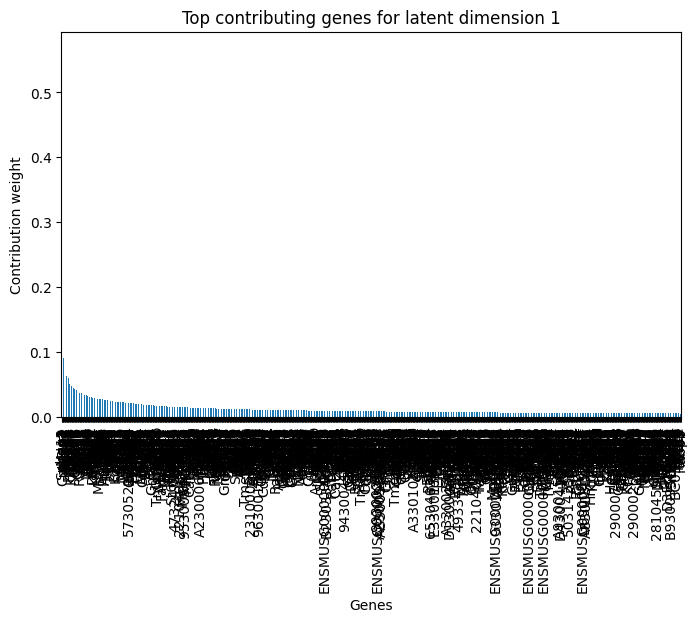

In [195]:
plot_top_contributing_genes(autoencoder, adata_test, latent_dim=1, top_n=1000)

# Latent dimensions heatmap

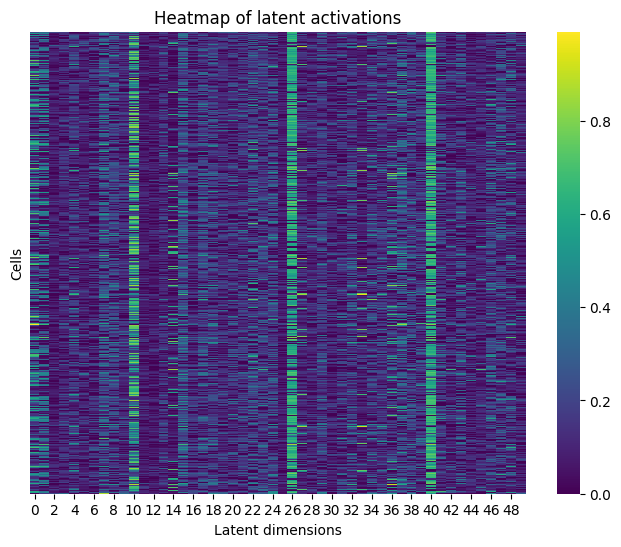

In [176]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_5xFAD', 'LD_NC', 'run_5xFAD', 'run_NC'])

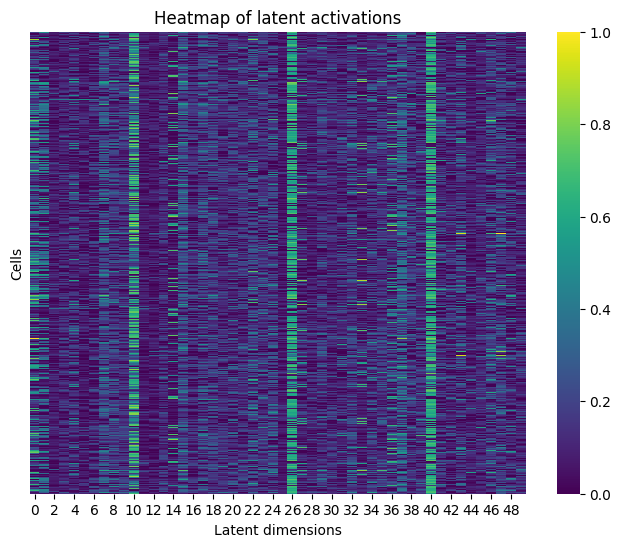

In [170]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_5xFAD'])

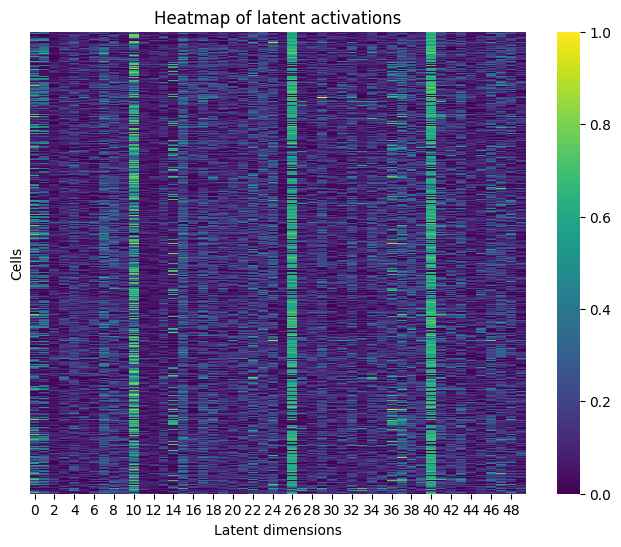

In [171]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["LD_NC"])

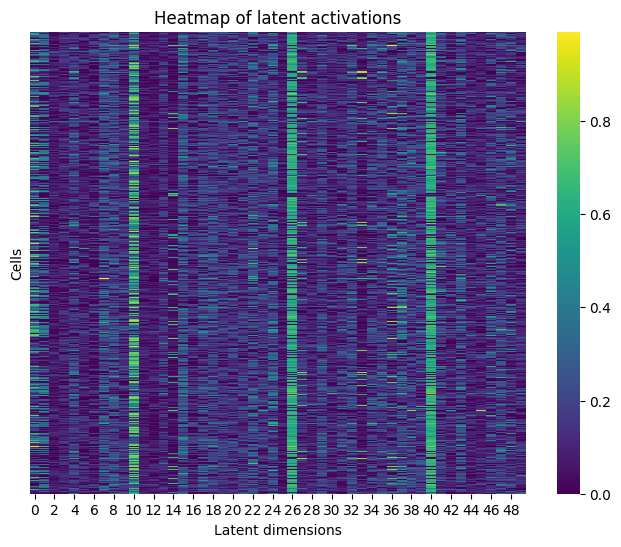

In [172]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["run_5xFAD"])

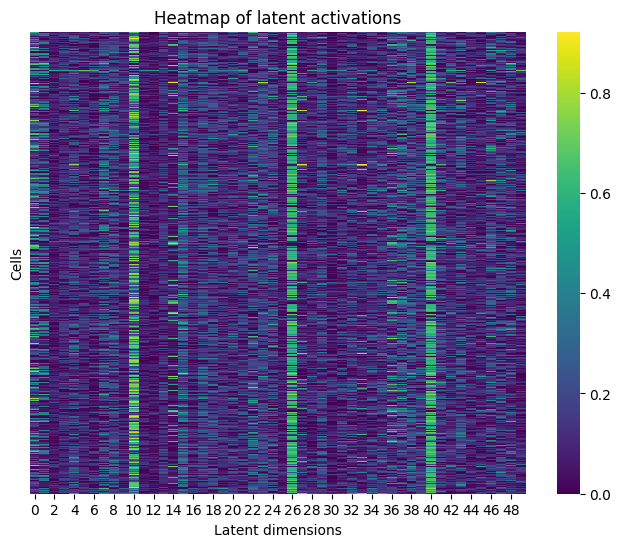

In [173]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['run_NC'])

# Visualize embedding

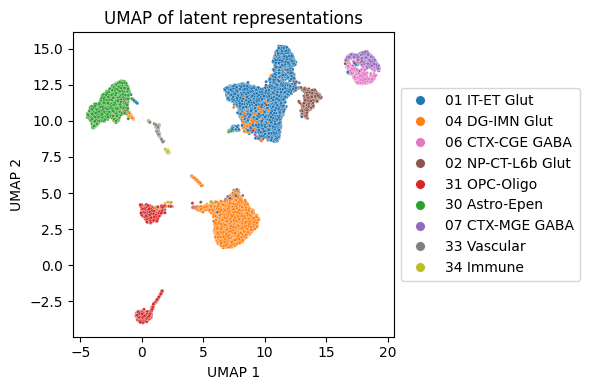

In [28]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC', 'LD_5xFAD', 'run_5xFAD', 'run_NC'], min_count=50)

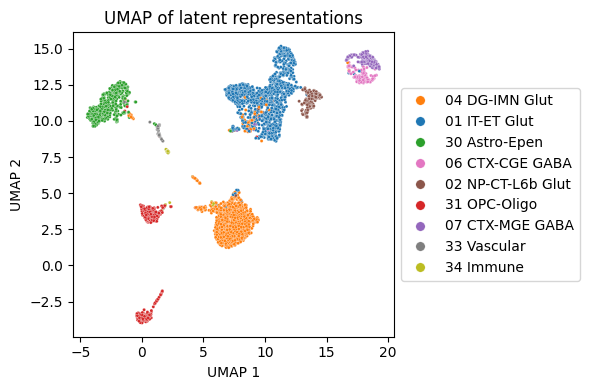

In [29]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_5xFAD'], min_count=50)

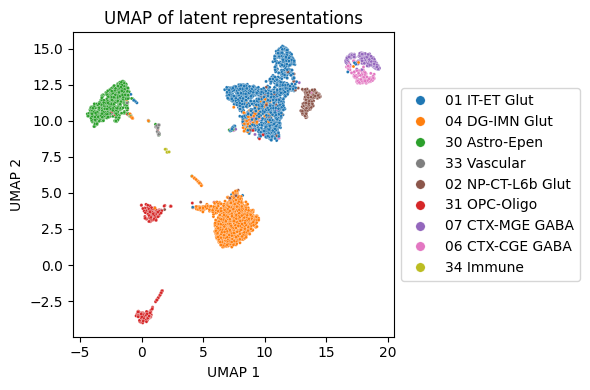

In [30]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC'], min_count=50)

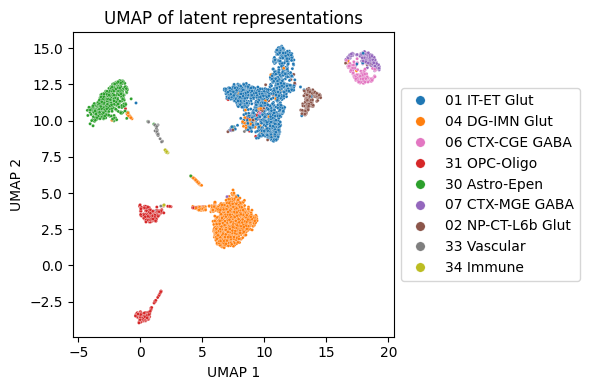

In [31]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_NC'], min_count=50)

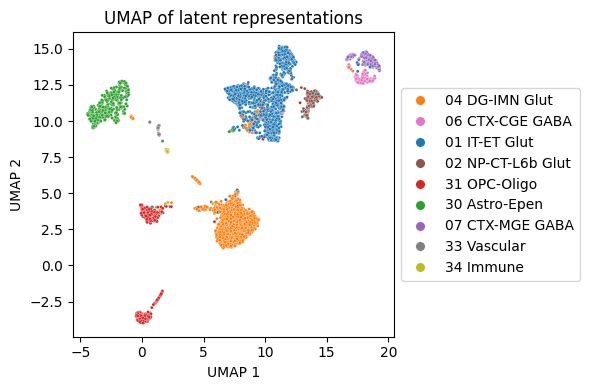

In [32]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_5xFAD'], min_count=50)

# Plot reconstructions

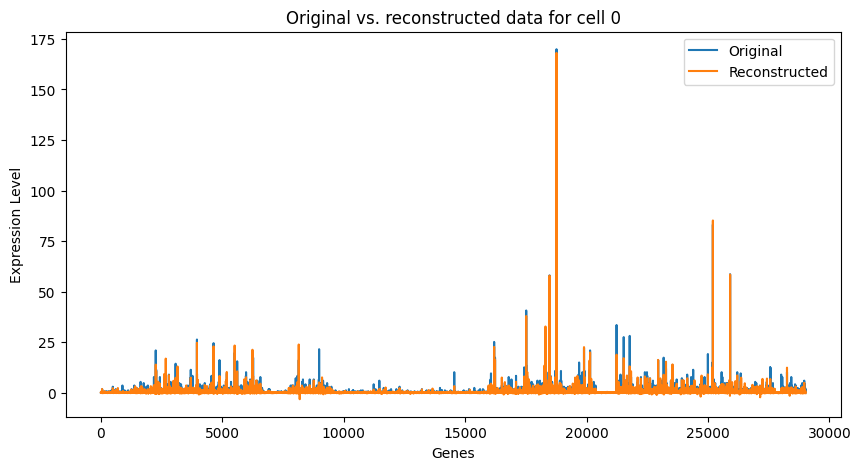

In [189]:
plot_cell_reconstruction(autoencoder, data, cell_idx=0)

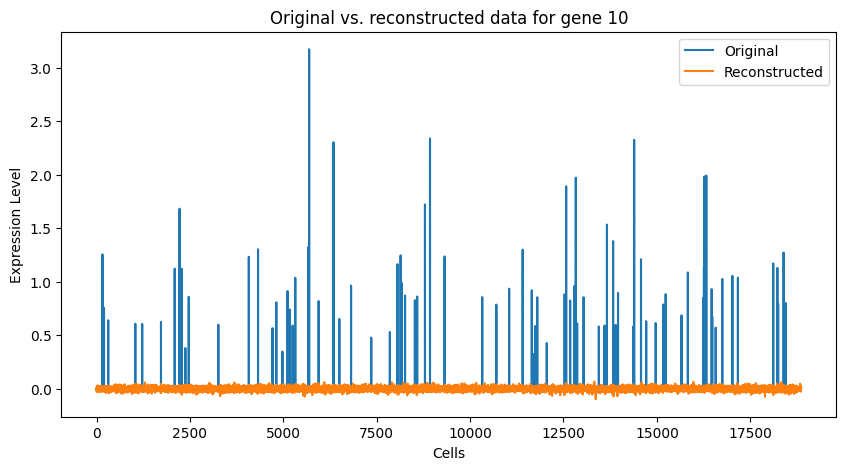

In [191]:
plot_gene_reconstruction(autoencoder, data, gene_idx=10)